# TODO:

- reduce image sizes
- create function for class percentages
- generate data
- train model

In [127]:
%autosave 120

Autosaving every 120 seconds


# Setup and Data Import

In [128]:
import cv2
import os
from matplotlib import pyplot as plt
from os.path import abspath
import numpy as np
import pandas as pd
import random

In [129]:
def local_or_hosted():

    if 'content' in os.getcwd():
        L_or_H = 'hosted'
      
    else:
        L_or_H = 'locally'
    
    return L_or_H

############

def colab_setup(L_or_H):

    if L_or_H == 'hosted':

        %cd -q /content/
        
        #check if git clone already performed
        if not os.path.isdir('./lymphoma_classifier'):
            !git clone https://github.com/andy-j-block/lymphoma_classifier.git
            
        %cd -q /content/lymphoma_classifier
        current_dir = os.getcwd()
        print(f"Current directory is '{current_dir}'")


############      

def load_images(images_main_dir):
    
    # get cancer type strings
    cancer_types = [type_ for type_ in os.listdir(images_main_dir)]

    # get directories where images are stored
    image_dirs = [os.path.join(images_main_dir, type_) for type_ in cancer_types]
    
    # read images into a list
    images = []

    for i, image_dir in enumerate(image_dirs):       
        image_files = os.listdir(image_dir)
        
        for j in image_files:

            # pass thru all the image files per image directory, read the image,
            # add it to the images list
            image_file = os.path.join(image_dirs[i], j)
            image = cv2.imread(image_file)          
            images.append((cancer_types[i], image, image_file))
                
    return cancer_types, image_dirs, images

I like to use Google Colab for its hosted runtime features so I include a check to see if the notebook is being run locally or hosted.

In [130]:
L_or_H = local_or_hosted()
print(f'This notebook running {L_or_H}.')

This notebook running hosted.


In [131]:
colab_setup(L_or_H)

Current directory is '/content/lymphoma_classifier'


Import the images and store them in a data structure

In [132]:
cancer_types, image_dirs, images = load_images('./Images')
print(f'Cancer types are {cancer_types}')
print(f'First image path: {images[:1][0][2]}\nFirst cancer type: {images[:1][0][0]}\nFirst image values:\n{images[:1][0][1]}')

Cancer types are ['CLL', 'FL', 'MCL']
First image path: ./Images/CLL/sj-05-5269-R10_007.tif
First cancer type: CLL
First image values:
[[[182 207 196]
  [183 207 199]
  [180 200 195]
  ...
  [121 107 158]
  [115 100 155]
  [106  90 142]]

 [[182 207 197]
  [184 207 201]
  [180 200 195]
  ...
  [122 107 154]
  [115 100 151]
  [106  90 145]]

 [[181 203 195]
  [182 203 195]
  [181 202 194]
  ...
  [121 103 143]
  [117 102 142]
  [109  95 143]]

 ...

 [[106  79 113]
  [108  79 108]
  [104  75 107]
  ...
  [157 154 180]
  [165 161 190]
  [162 151 183]]

 [[102  78 112]
  [101  78 111]
  [ 99  78 116]
  ...
  [153 147 169]
  [168 164 187]
  [168 160 189]]

 [[106  87 125]
  [106  87 120]
  [103  88 125]
  ...
  [155 137 153]
  [169 165 181]
  [177 171 186]]]


Create pandas DataFrame

In [133]:
df = pd.DataFrame(images, columns=['cancer_type', 'image', 'image_path'])
df.head(3)

,cancer_type,image,image_path
0,CLL,"[[[182, 207, 196], [183, 207, 199], [180, 200,...",./Images/CLL/sj-05-5269-R10_007.tif
1,CLL,"[[[151, 127, 131], [154, 127, 137], [162, 127,...",./Images/CLL/sj-05-3344_002.tif
2,CLL,"[[[139, 118, 130], [137, 118, 140], [137, 119,...",./Images/CLL/sj-03-2810_004.tif


# Exploratory Data Analysis

In [134]:
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

In [172]:
def show_value_counts(series):

    print(f'The value counts are:\n{series.value_counts()}')

    percentages = [i/len(df) for i in series.value_counts().values]
    percentages = [round(i,2) for i in percentages]

    fig, ax = plt.subplots(1,1,figsize=(10,5))

    bar_chart=ax.bar(x=series.value_counts().index, 
                    height=series.value_counts().values)

    # Grabbed from matplotlib documentation:
    # https://matplotlib.org/2.0.2/examples/api/barchart_demo.html
    def autolabel(bar_chart, text_labels):
        for i, bar in enumerate(bar_chart):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    text_labels[i],
                    ha='center', va='bottom')# rotation=0?)
            
    autolabel(bar_chart, percentages)

    plt.title('Count by cancer type with percentages as text')
    plt.show()

############

def get_image_dims(series):

    img_heights = []
    img_widths = []

    for i in range(len(series)):
        img = series.iloc[i]
        img_heights.append(img.shape[0])
        img_widths.append(img.shape[1])

    img_heights = set(img_heights)
    img_widths = set(img_widths)
        
    print('Image heights are: ', set(img_heights))
    print('Image widths are: ', set(img_widths))

    return img_heights, img_widths

############

def get_intensity_range(series):

    maxs = []
    mins = []

    for i, _ in enumerate(series):
        
        maxs.append(np.amax(series.values[i]))
        mins.append(np.amin(series.values[i]))

    print(f'The highest intesity in the range: {max(maxs)}')
    print(f'The lowest intesity in the range: {min(mins)}')

############

def get_random_image():

    rand_imgs = []

    for i in image_dirs:
        rand_img = random.choice(os.listdir(i))
        rand_img = os.path.join(i,rand_img)
        rand_img = Image.open(rand_img)
        rand_imgs.append(rand_img)

    fig, axs = plt.subplots(1, len(rand_imgs), figsize=(30,10))

    for i, img in enumerate(rand_imgs):
        axs[i].set_title(f'Cancer type: {cancer_types[i]}')
        axs[i].imshow(img)

############

def reduce_image_size(series, factor, filter):

    # Filter can be one of Image.NEAREST, Image.BOX, Image.BILINEAR, 
    # Image.HAMMING, Image.BICUBIC or Image.LANCZOS.
    # Default filter is Image.BICUBIC

    for idx, img in enumerate(series.values):
        im = Image.fromarray(img)
        (width, height) = (im.width // factor, im.height // factor)
        im = im.resize((width, height))
        im = np.array(im)
        series.iloc[idx] = im

Let's look at the class distribution

The value counts are:
FL     139
MCL    122
CLL    113
Name: cancer_type, dtype: int64


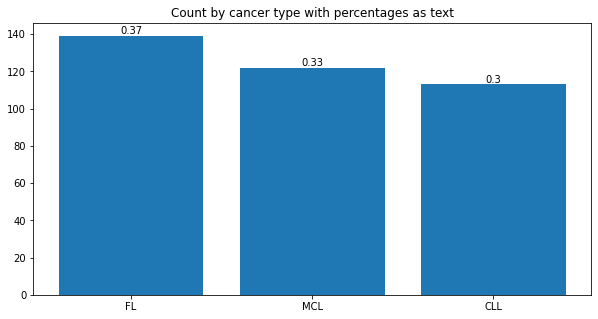

In [136]:
show_value_counts(df['cancer_type'])

Let's confirm image size

In [137]:
img_heights, img_widths = get_image_dims(df['image'])

Image heights are:  {1040}
Image widths are:  {1388}


Single value sets mean all images with the same height and width.  Let's confirm the pixel color intensity range

In [138]:
get_intensity_range(df['image'])

The highest intesity in the range: 255
The lowest intesity in the range: 2


I think it's safe to say that these RGB color values range from (0,255).  Color scaling later on will reflect this range

Let's look at a random image of each cancer type.

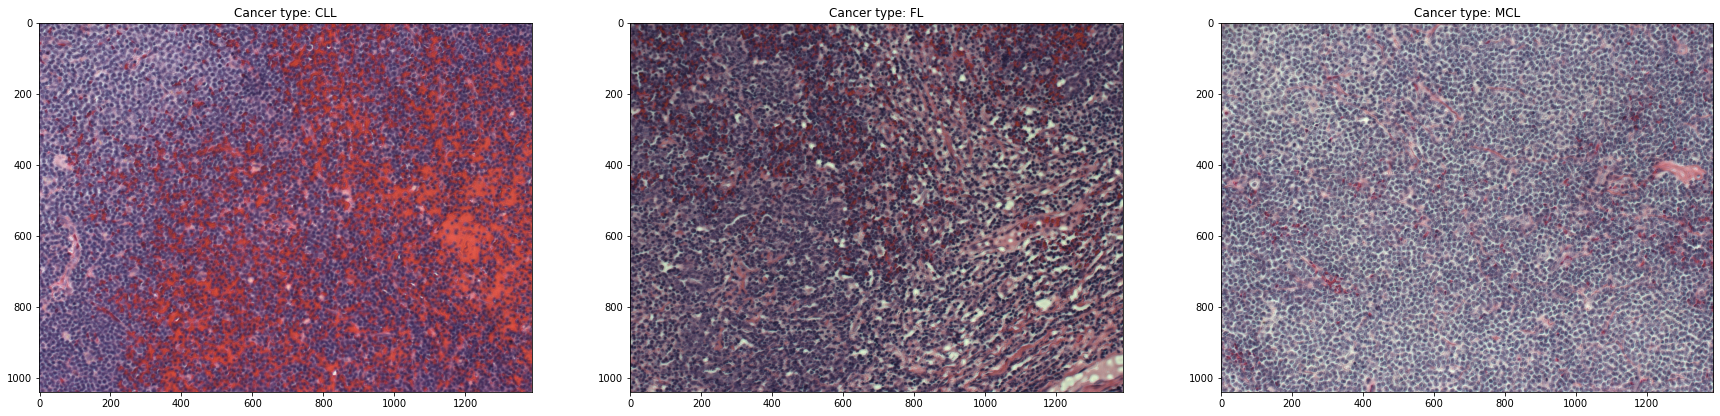

In [139]:
get_random_image()

In [173]:
reduce_image_size(df['image'], 4, Image.BILINEAR)
img_heights, img_widths = get_image_dims(df['image'])
get_intensity_range(df['image'])

Image heights are:  {16}
Image widths are:  {21}
The highest intesity in the range: 213
The lowest intesity in the range: 14


### Define some useful constants for later

In [145]:
image_height = img_heights.pop()
image_width = img_widths.pop()
image_size = (image_width, image_height)
image_channels = 3

# Prepare Data

In [148]:
from PIL import Image
from sklearn.model_selection import train_test_split

In [166]:
def visualize_sets(full_series, train_series, test_series, titles):

    series = [full_series, train_series, test_series]

    percentages = []
    
    for i, series_ in enumerate(series):

        percentage = [j/len(series_) for j in series_.value_counts().values]
        percentage = [round(j,2) for j in percentage]
        percentages.append(percentage)

    fig, ax = plt.subplots(1,len(series),figsize=(20,5))

    dfs=[]

    for i, series_ in enumerate(series):

        df = ax[i].bar(x=series_.value_counts().index, 
                    height=series_.value_counts().values)
        
        dfs.append(df)

    # Grabbed from matplotlib documentation:
    # https://matplotlib.org/2.0.2/examples/api/barchart_demo.html
    def autolabel(bar_charts, text_labels):
        for i, chart in enumerate(bar_charts):
            for j, bar in enumerate(chart):
                height = bar.get_height()
                ax[i].text(bar.get_x() + bar.get_width()/2., height,
                        text_labels[i][j],
                        ha='center', va='bottom')# rotation=0?)
            
    autolabel(dfs, percentages)

    for i, title in enumerate(titles):
        ax[i].set_title(title)
    
    plt.show()

############

def index_resetter(df):
    
    df = df.reset_index(drop=True)



We want to create a holdout test set now, but we don't want to split the target variable yet from the image and its path.  When we move onto data generation, we need to keep the target available, so we will just separate the dataframe as a whole.

In [149]:
df_train, df_test = train_test_split(df, test_size=0.2, stratify=df['cancer_type'], random_state=42) 

In [150]:
print(df_train.shape, df_test.shape)

(299, 3) (75, 3)


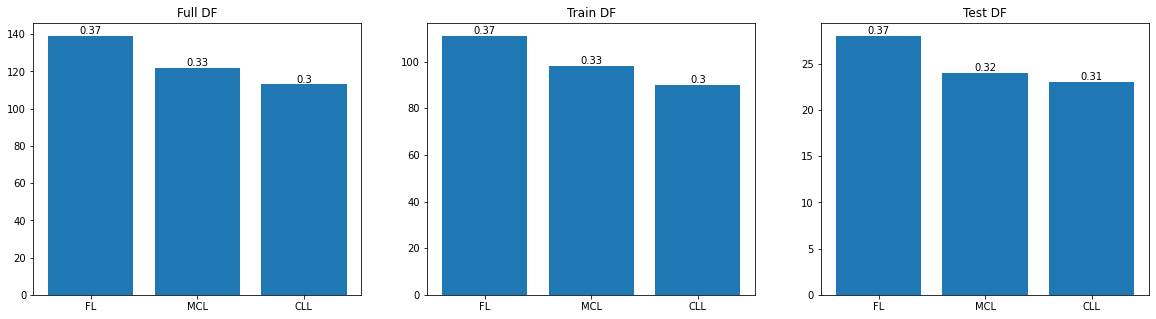

In [165]:
visualize_sets(df['cancer_type'], df_train['cancer_type'], df_test['cancer_type'], ['Full DF', 'Train DF', 'Test DF'])

In [167]:
df_test.head(3)

,cancer_type,image,image_path
282,MCL,"[[[88, 54, 114], [85, 52, 118], [97, 61, 117],...",./Images/MCL/sj-05-5326-R1_011.tif
99,CLL,"[[[143, 122, 121], [156, 138, 140], [151, 133,...",./Images/CLL/sj-03-4957_006.tif
350,MCL,"[[[153, 147, 154], [151, 144, 154], [144, 132,...",./Images/MCL/sj-04-3077-R2_001.tif


Let's just reset the index here for clarity.

In [168]:
index_resetter(df_test)
df_test.head(2)

,cancer_type,image,image_path
282,MCL,"[[[88, 54, 114], [85, 52, 118], [97, 61, 117],...",./Images/MCL/sj-05-5326-R1_011.tif
99,CLL,"[[[143, 122, 121], [156, 138, 140], [151, 133,...",./Images/CLL/sj-03-4957_006.tif


In [169]:
df_test['cancer_type'].value_counts()

FL     28
MCL    24
CLL    23
Name: cancer_type, dtype: int64

# Data Generation

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

#### Transform for cancer type to label encoding and split the data again

In [ ]:
df_train['cancer_type'] = df_train['cancer_type'].replace({'CLL':0, 'FL':1, 'MCL':2})  

<ipython-input-178-3009f5933a0c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['cancer_type'] = df_train['cancer_type'].replace({'CLL':0, 'FL':1, 'MCL':2})


In [ ]:
df_train.head(2)

,cancer_type,image,image_path
192,1,"[[[105, 80, 77], [101, 80, 79], [107, 86, 86],...",C:\Users\abloc\Documents\Cancer Project\Images...
75,0,"[[[145, 132, 146], [146, 132, 138], [129, 116,...",C:\Users\abloc\Documents\Cancer Project\Images...


The data needs to be split again before generation can occur, that was the validation set generated data doesn't get into the training set.

In [ ]:
df_train, df_valid = train_test_split(df_train, test_size=0.2, random_state=42)

In [ ]:
df_train.head(3)

,cancer_type,image,image_path
125,FL,"[[[169, 178, 170], [167, 178, 175], [160, 177,...",C:\Users\abloc\Documents\Cancer Project\Images...
88,CLL,"[[[84, 40, 63], [83, 40, 63], [79, 38, 60], [8...",C:\Users\abloc\Documents\Cancer Project\Images...
359,MCL,"[[[148, 130, 144], [142, 130, 146], [142, 133,...",C:\Users\abloc\Documents\Cancer Project\Images...


Again, let's reset our indices.

In [ ]:
index_resetter(df_train)
index_resetter(df_valid)

Time to create our data generation schema.

In [ ]:
train_datagen = ImageDataGenerator(
                                    rescale=1./255,
                                    shear_range=0.1,
                                    zoom_range=0.1,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    horizontal_flip=True)

train_generator = train_datagen.flow_from_dataframe(
                                                    df_train,
                                                    x_col='image_path',
                                                    y_col='cancer_type',
                                                    target_size=image_size,
                                                    class_mode='categorical')

Found 239 validated image filenames belonging to 3 classes.


Run the data generator on an example image.

In [ ]:
df_gen_test = df_train.sample(n=1).reset_index(drop=True)
generator_test = train_datagen.flow_from_dataframe(
                                                        df_gen_test,
                                                        x_col='image_path',
                                                        y_col='cancer_type',
                                                        target_size=image_size,
                                                        class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


In [ ]:
generator_test

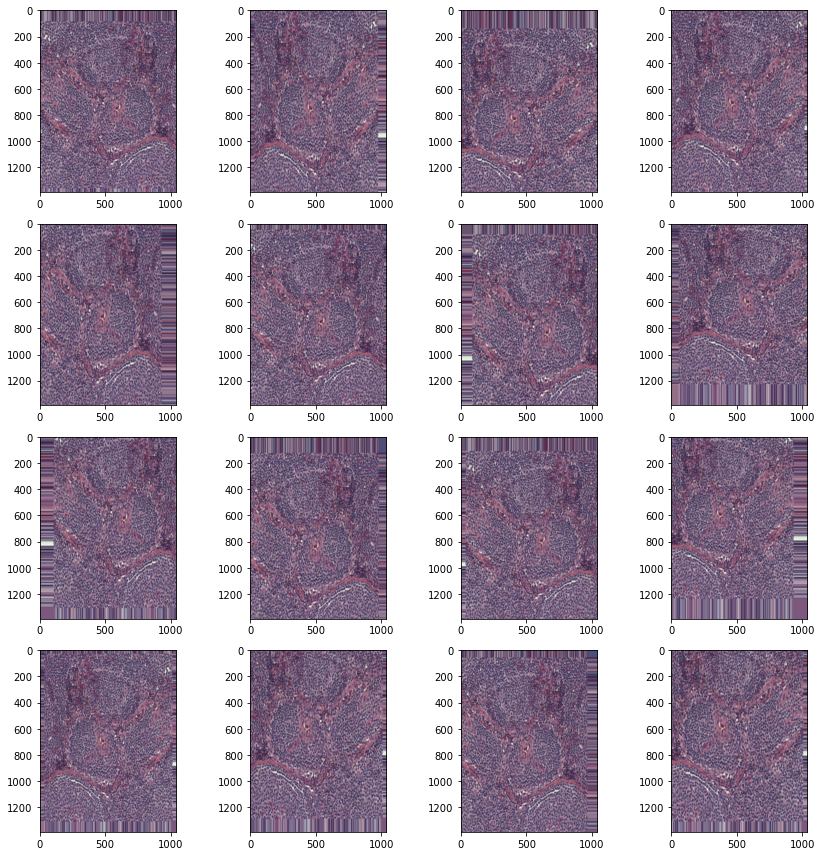

In [ ]:
plt.figure(figsize=(12, 12))
for i in range(0, 16):
    plt.subplot(4, 4, i+1)
    for X_batch, Y_batch in generator_test:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [ ]:
valid_datagen = ImageDataGenerator(rescale=1./255)

valid_generator = train_datagen.flow_from_dataframe(
                                                    df_valid,
                                                    x_col='image_path',
                                                    y_col='cancer_type',
                                                    target_size=image_size,
                                                    class_mode='categorical')

Found 60 validated image filenames belonging to 3 classes.



# Model Build

In [ ]:
from torch import nn as nn
from torch import functional as F

In [ ]:
model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(image_width, image_height, image_channels)))
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(len(cancer_types), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

ResourceExhaustedError: OOM when allocating tensor with shape[1431040,512] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu [Op:Add]

# Train the Model



In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
early_stop = EarlyStopping(patience=20)
reduce_lr = ReduceLROnPlateau(monitor='val_acc', 
                                            factor=0.2,
                                            patience=5, 
                                            verbose=1,
                                            min_lr=0.00001)

In [ ]:
batch = 32

history = model.fit_generator(
    train_generator, 
    epochs=50,
    validation_data=validation_generator,
    validation_steps=len(df_valid)//batch_size,
    steps_per_epoch=len(df_train)//batch_size,
    callbacks=[early_stop, reduce_lr]
)